# Marine Heatwaves forecast using NMME (North American Multi-Model Ensemble)

The notebook go throught the following steps 
- lazy loading the NMME model data from IRI/LDEO Climate Data Library (http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/)
- calculate the ensemble mean climatology for specific model based on hindcast
- calculate the anomaly of forecast
- calculate the threshold based on SST anomaly with three month window for each initial time and associated lead time.
- calculate the marine heatwave from the forecast anomaly based on the determined threshold
- show result

## Import needed python package

In [ ]:
# if running google colab next line (uncomment the line) need to be executed to get the necessary backend pydap support in the later on code
# !pip install pydap

In [5]:
import warnings
import cftime
import numpy as np
import xarray as xr
from dask.diagnostics import ProgressBar

warnings.simplefilter("ignore")

## Define functions 

In [6]:
def nmme_3mon_quantile(da_data, mhw_threshold=90.):
    """
    This function is designed for calculating the nmme 
    marine heat wave threshold.
    
    The threshold is calculated using a 3 month window
    to identified the X quantile value for each month.

    Parameters
    ----------
    da_data : xr.DataArray 
        For marine heat wave calculation, it should be the sst DataArray. 
        Since this function is designed for NMME model. The DataArray need 
        to be in the format of NMME model output.
    mhw_threshold : float
        the X quantile one wants to calculate. 

    Returns
    -------
    da_data_quantile : xr.DataArray
        The xr.DataArray for the quantile 

    Raises
    ------

    """
    
    da_data_quantile = xr.DataArray(coords={'X':da_data.X,
                                            'Y':da_data.Y,
                                            'month':np.arange(1,2),
                                            'L':da_data.L},
                                    dims = ['month','L','Y','X'])

    for i in range(1,2):
        print(f"calculate month{i} threshold")
        if i == 1:
            mon_range = [12,1,2]
        elif i == 12 :
            mon_range = [11,12,1]
        else:
            mon_range = [i-1,i,i+1]

        da_data_quantile[i-1,:,:,:] = (da_data
                                 .where((da_data['S.month'] == mon_range[0])|
                                        (da_data['S.month'] == mon_range[1])|
                                        (da_data['S.month'] == mon_range[2]),drop=True)
                                 .stack(allens=('S','M'))
                                 .quantile(mhw_threshold*0.01, dim = 'allens', interpolation='linear',skipna = True))

    return da_data_quantile
    


            

## Lazy loading the NMME model data from IRI/LDEO Climate Data Library

In [7]:
#### The opendap access
model_list = ['GFDL-SPEAR']
forecast_list = ['http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.%s/.FORECAST/.MONTHLY/.sst/dods'%model for model in model_list] 

hindcast_list = ['http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.%s/.HINDCAST/.MONTHLY/.sst/dods'%model for model in model_list] 

In [8]:
# hindcast opendap
dict_model_hindcast = {}
for nmodel,link in enumerate(hindcast_list):
    dict_model_hindcast[model_list[nmodel]] = xr.open_dataset(link, engine='pydap',chunks={'M':1,'L':1,'S':1},decode_times=False)

In [9]:
# forecast opendap
dict_model_forecast = {}
for nmodel,link in enumerate(forecast_list):
    dict_model_forecast[model_list[nmodel]] = xr.open_dataset(link, engine='pydap',chunks={'M':1,'L':1,'S':1},decode_times=False)

### Decoding the time axis manually

In [10]:
for nmodel,model in enumerate(model_list):
    print(model)
    dict_model_hindcast[model]['S'] = cftime.num2date(dict_model_hindcast[model].S.values,
                                                      'months since 1960-01-01',
                                                      calendar='360_day')
    dict_model_forecast[model]['S'] = cftime.num2date(dict_model_forecast[model].S.values,
                                                      'months since 1960-01-01',
                                                      calendar='360_day')

GFDL-SPEAR


In [11]:
dict_model_hindcast['GFDL-SPEAR'].S

<xarray.DataArray 'S' (S: 360)>
array([cftime.Datetime360Day(1991, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1991, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1991, 3, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.Datetime360Day(2020, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2020, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2020, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * S        (S) object 1991-01-01 00:00:00 ... 2020-12-01 00:00:00

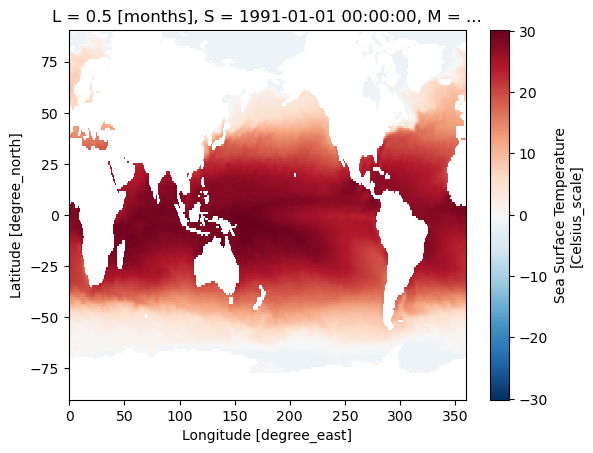

In [12]:
dict_model_hindcast['GFDL-SPEAR'].sst.isel(S=0,M=0,L=0).plot()

In [13]:
dict_model_forecast['GFDL-SPEAR'].S

<xarray.DataArray 'S' (S: 27)>
array([cftime.Datetime360Day(2020, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2021, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2021, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2021, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2021, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2021, 5, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2021, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2021, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2021, 8, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2021, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2021, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2021, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2021, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2022, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2022, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2022, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2022, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2022, 5, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2022, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2022, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2022, 8, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2022, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2022, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2022, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2022, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2023, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2023, 2, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * S        (S) object 2020-12-01 00:00:00 ... 2023-02-01 00:00:00

## Calculate the ensemble mean climatology 
This is based on hindcast for specific model. If there are more than one model, each model will have its own ensemble mean climatology. 

For demostration, the climatology period is only based on one year which does not make sense scientifically. For scientific purpose, the hindcast should at least has 30 years of data to calculate the climatology.

In [14]:
start_year = 2020
end_year = 2020

In [15]:

for nmodel,model in enumerate(model_list):
    print('-------------')
    print(model)
    print('-------------')

    # crop data to the desired period
    with ProgressBar():
        da_model = (
            dict_model_hindcast[model]
            .sst
            .sel(S=slice(f'{start_year-1}-12-01',f'{end_year}-03-01'))
        ).compute()
        
    # calculate ensemble mean
    print('calculate ensemble mean')
    da_ensmean = da_model.mean(dim='M')

    # calculate ensemble mean climatology
    print('calculate climatology')
    da_ensmean_climo = da_ensmean.groupby('S.month').mean(dim='S')


-------------
GFDL-SPEAR
-------------
[########################################] | 100% Completed | 30.30 s
calculate ensemble mean
calculate climatology


In [16]:
da_ensmean

<xarray.DataArray 'sst' (S: 12, L: 12, Y: 181, X: 360)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [-1.8152167 , -1.7997636 , -1.8374307 , ..., -1.7942959 ,
          -1.8131804 , -1.8267497 ],
         [-1.8465025 , -1.8499216 , -1.8553926 , ..., -1.8044785 ,
          -1.8234142 , -1.8409054 ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [-0.40647423, -0.32241496, -0.32639506, ..., -1.2913983 ,
          -1.0387492 , -0.67631894],
         [-0.53427947, -0.25783926, -0.15042621, ..., -1.2976335 ,
          -1.157531  , -0.9127232 ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [-1.3329976 , -1.2299353 , -1.227057  , ..., -1.6917287 ,
          -1.6293875 , -1.4921345 ],
         [-1.4859961 , -1.4001585 , -1.3600676 , ..., -1.7011333 ,
          -1.6687951 , -1.5964279 ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]], dtype=float32)
Coordinates:
  * Y        (Y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * S        (S) object 2020-01-01 00:00:00 ... 2020-12-01 00:00:00
  * X        (X) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0

In [17]:
da_ensmean_climo

<xarray.DataArray 'sst' (month: 12, L: 12, Y: 181, X: 360)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [-1.8152167 , -1.7997636 , -1.8374307 , ..., -1.7942959 ,
          -1.8131804 , -1.8267497 ],
         [-1.8465025 , -1.8499216 , -1.8553926 , ..., -1.8044785 ,
          -1.8234142 , -1.8409054 ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [-0.40647423, -0.32241496, -0.32639506, ..., -1.2913983 ,
          -1.0387492 , -0.67631894],
         [-0.53427947, -0.25783926, -0.15042621, ..., -1.2976335 ,
          -1.157531  , -0.9127232 ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [-1.3329976 , -1.2299353 , -1.227057  , ..., -1.6917287 ,
          -1.6293875 , -1.4921345 ],
         [-1.4859961 , -1.4001585 , -1.3600676 , ..., -1.7011333 ,
          -1.6687951 , -1.5964279 ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]], dtype=float32)
Coordinates:
  * Y        (Y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * X        (X) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

## Calculate the anomaly of forecast

### Load one initial time of forecast anomaly data for demo

In [18]:
for nmodel,model in enumerate(model_list):
    print('-------------')
    print(model)
    print('-------------')

    # crop data to the desired period
    with ProgressBar():
        da_model_forecast = dict_model_forecast[model].sst.sel(S="2022-01").compute()
        
print('calculating anomaly from forecast')
da_model_forecast = (da_model_forecast.groupby('S.month') - da_ensmean_climo)

-------------
GFDL-SPEAR
-------------
[########################################] | 100% Completed | 3.53 sms
calculating anomaly from forecast


## Calculate the threshold
The threshold is based on the hindcast SST anomaly with a three month window (initial months) for each initial time and associated lead time as the centered month.

In [19]:
print('calculating anomaly from hindcast')
da_anom = (da_model.groupby('S.month') - da_ensmean_climo)

ds_mhw_threshold = xr.Dataset()

mhw_threshold = [90]
for m in mhw_threshold:

    print(f'calculating threshold {m}')
    da_threshold = nmme_3mon_quantile(da_anom, mhw_threshold=m)
    ds_mhw_threshold[f'threshold_{m}'] = da_threshold

calculating anomaly from hindcast
calculating threshold 90
calculate month1 threshold


In [20]:
da_threshold

<xarray.DataArray (month: 1, L: 12, Y: 181, X: 360)>
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [0.03974178, 0.03800244, 0.0391201 , ..., 0.02901187,
          0.02458122, 0.02564578],
         [0.02360184, 0.02258537, 0.02060158, ..., 0.02521191,
          0.02393916, 0.02910042],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
...
         [0.72357243, 0.60701573, 0.54283649, ..., 0.13175932,
          0.35675725, 0.6419211 ],
         [0.62255663, 0.60225141, 0.72256112, ..., 0.19328113,
          0.36650369, 0.4901906 ],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [0.25853935, 0.34564194, 0.32497716, ..., 0.03309548,
          0.03499634, 0.1149836 ],
         [0.03902881, 0.0555923 , 0.10839014, ..., 0.03512161,
          0.04036186, 0.04238491],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]]]])
Coordinates:
  * X        (X) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * Y        (Y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * month    (month) int64 1
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5

## Calculate the marine heatwave 
Using the forecast anomaly and the determined threshold, we can identify the marine heatwave in the forecast.

In [21]:
ds_mhw = xr.Dataset()

for m in mhw_threshold:

    print(f'calculating MHW {m}')
    da_mhw = da_model_forecast.where(da_model_forecast.groupby('S.month')>=ds_mhw_threshold[f'threshold_{m}'])
    ds_mhw[f'mhw_{m}'] = da_mhw

calculating MHW 90


In [22]:
da_mhw

<xarray.DataArray 'sst' (S: 1, L: 12, M: 30, Y: 181, X: 360)>
array([[[[[       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          ...,
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
           0.02415383, 0.029356  ],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan]],

         [[       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
...
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan]],

         [[       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          ...,
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ..., 0.05839467,
           0.05956662, 0.05180919],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan]]]]], dtype=float32)
Coordinates:
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * S        (S) object 2022-01-01 00:00:00
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 26.0 27.0 28.0 29.0 30.0
  * X        (X) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * Y        (Y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
    month    (S) int64 1

## Show result

### Define plot format function

In [24]:
def plot_format(ax,font_size=10):
    # ax.coastlines(resolution='110m',linewidths=0.8)
    # ax.add_feature(cfeature.LAND,color='lightgrey')

    ax.set_xticks([60,120,180,240,300])
    ax.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=font_size)
    ax.set_yticks([-90,-60,-30,0,30,60,90])
    ax.set_yticklabels([-90,-60,-30,0,30,60,90], color='black', weight='bold',size=font_size)
    ax.yaxis.tick_left()

    # lon_formatter = cticker.LongitudeFormatter()
    # lat_formatter = cticker.LatitudeFormatter()
    # ax.xaxis.set_major_formatter(lon_formatter)
    # ax.yaxis.set_major_formatter(lat_formatter)
    ax.grid(linewidth=2, color='black', alpha=0.1, linestyle='--')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect('auto')
    
    return ax

### Show threshold, MHW, and SST anomaly

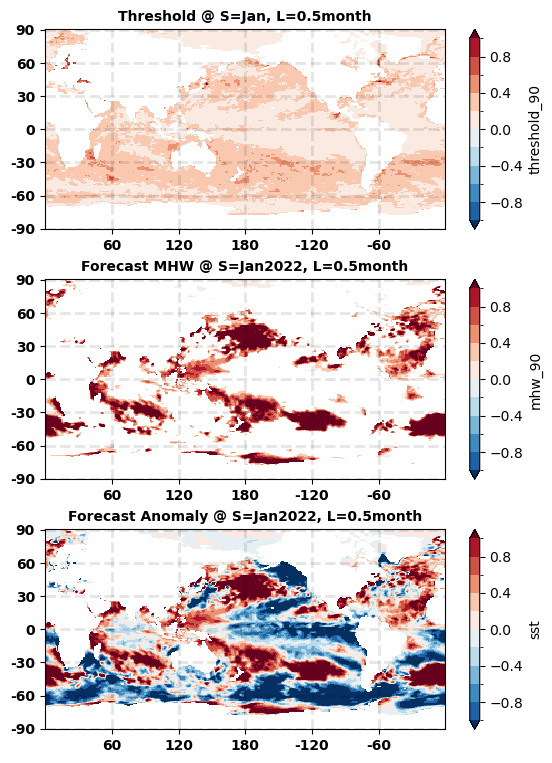

In [25]:
# comparing zos  
# import cartopy.mpl.ticker as cticker
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(2,figsize=(10,10))
fontsize = 10
level = np.linspace(-1, 1, 11)

# threshold figure
ax2 = fig.add_axes([0,0.5,0.5,0.20])
im = (
    ds_mhw_threshold
        .isel(month=0,L=0).threshold_90
        .plot.pcolormesh(
            x='X',
            y='Y',
            ax=ax2, 
            levels=level, 
            extend='both', 
            cmap='RdBu_r'
        )
)
ax2.set_title('Threshold @ S=Jan, L=0.5month', color='black', weight='bold',size=fontsize)
ax2 = plot_format(ax2,font_size=fontsize)


# mhw figure
ax3 = fig.add_axes([0,0.25,0.5,0.20])
im = (
    ds_mhw
        .isel(S=0,L=0,M=0).mhw_90
        .plot.pcolormesh(
            x='X',
            y='Y',
            ax=ax3, 
            levels=level, 
            extend='both', 
            cmap='RdBu_r'
        )
)
ax3.set_title('Forecast MHW @ S=Jan2022, L=0.5month', color='black', weight='bold',size=fontsize)
ax3 = plot_format(ax3,font_size=fontsize)

# anomaly figure
ax4 = fig.add_axes([0,0,0.5,0.20])
im = (
    da_model_forecast
        .isel(S=0,L=0,M=0)
        .plot.pcolormesh(
            x='X',
            y='Y',
            ax=ax4, 
            levels=level, 
            extend='both', 
            cmap='RdBu_r'
        )
)
ax4.set_title('Forecast Anomaly @ S=Jan2022, L=0.5month', color='black', weight='bold',size=fontsize)
ax4 = plot_format(ax4,font_size=fontsize)




### calculate MHW event
- not a number as no MHW
- 1 as one identified MHW 

In [26]:
da_mhw_event = (ds_mhw.isel(S=0,L=11).mhw_90/ds_mhw.isel(S=0,L=11).mhw_90)

In [27]:
da_mhw_event

<xarray.DataArray 'mhw_90' (M: 30, Y: 181, X: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [ 1., nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ...,  1.,  1.,  1.],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    L        float32 11.5
    S        object 2022-01-01 00:00:00
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 26.0 27.0 28.0 29.0 30.0
  * X        (X) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * Y        (Y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
    month    int64 1

### Show all enesemble member identified MHW 
this is for specific start time (S = 2022 Jan) and lead time (11.5 months - 2022 Dec)

In [28]:
da_landmask = da_model_forecast.isel(L=0,M=0,S=0)/da_model_forecast.isel(L=0,M=0,S=0)

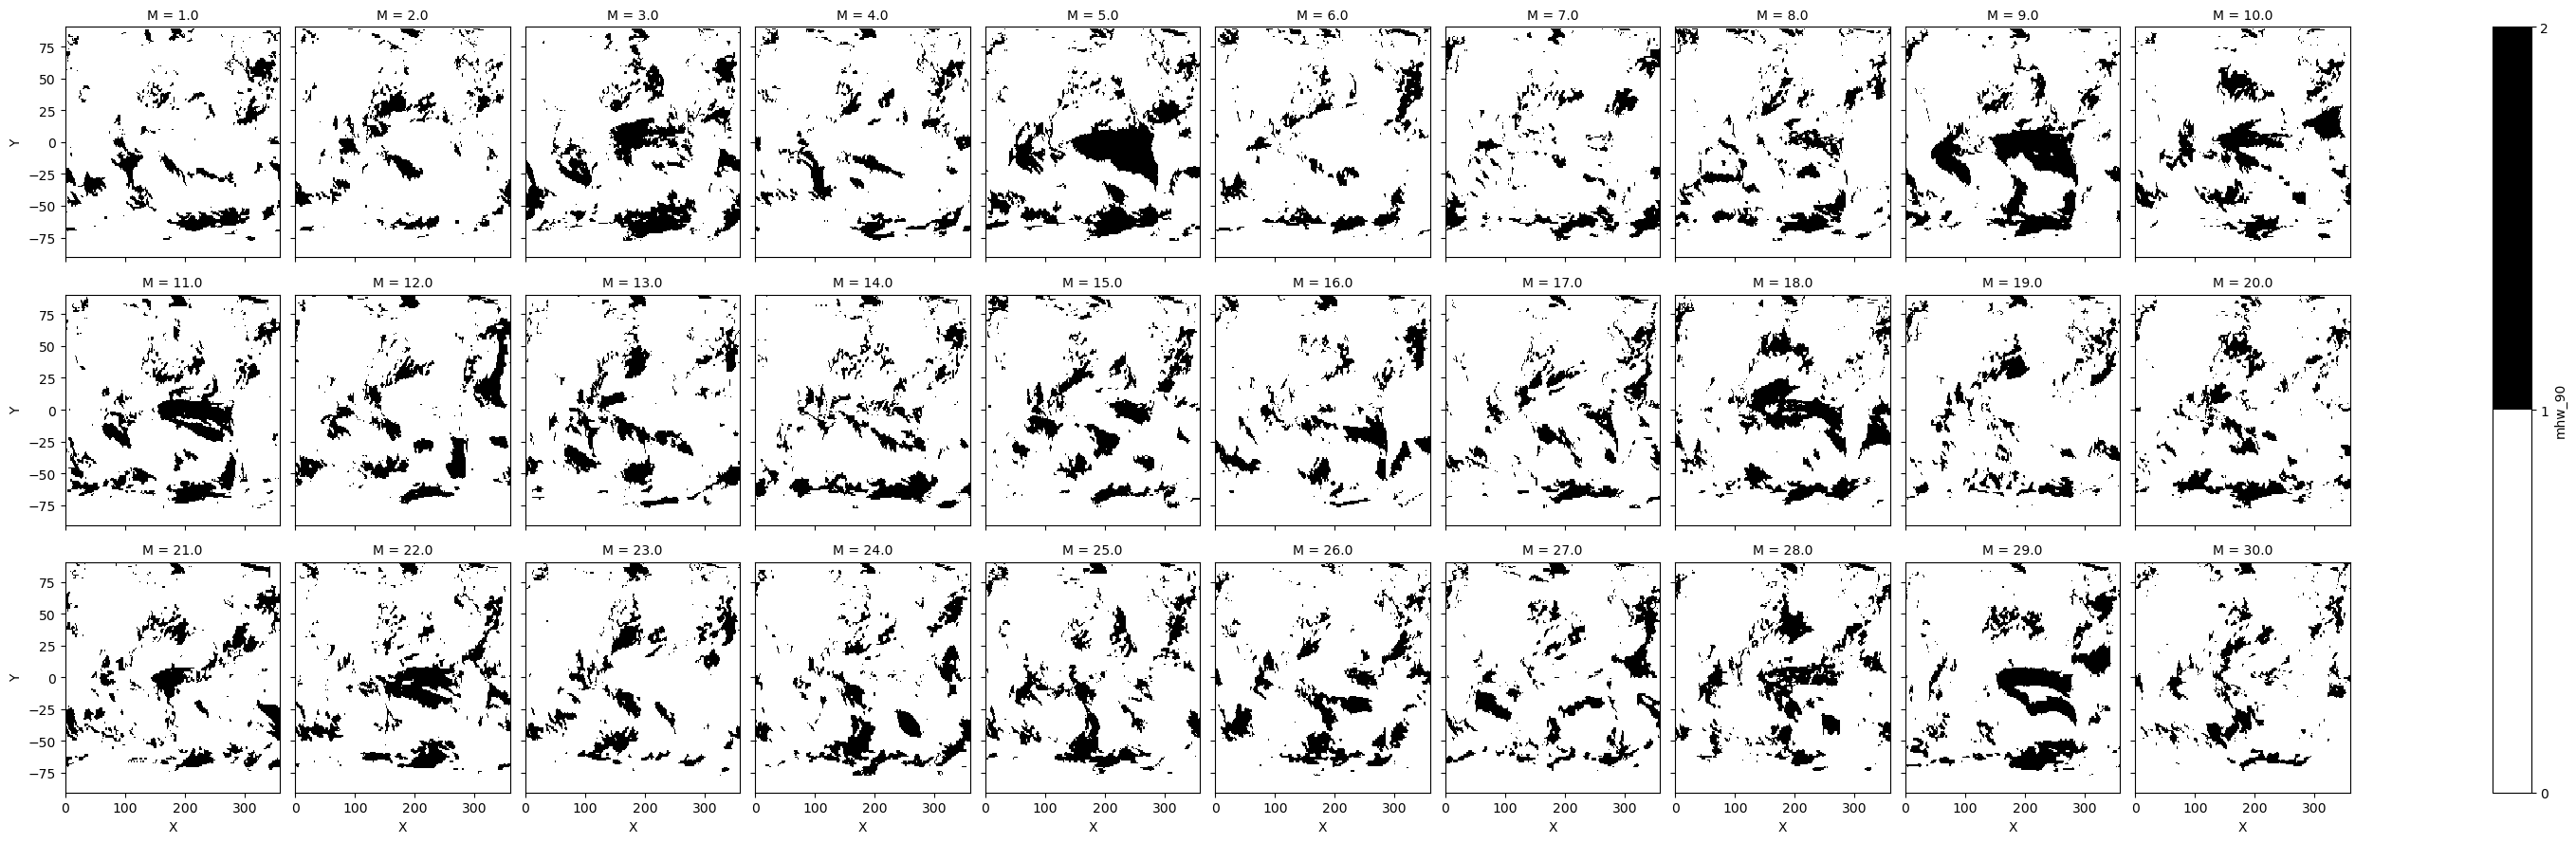

In [29]:
da_mhw_event.plot(x="X",y='Y',col='M',col_wrap=10,cmap='Greys',levels=np.arange(0,2+1))

In [30]:
da_mhw_event.max().values

array(1., dtype=float32)

### Show total identified MHW in ensemble and associated probably

this is for specific start time (S = 2022 Jan) and lead time (11.5 months - 2022 Dec)


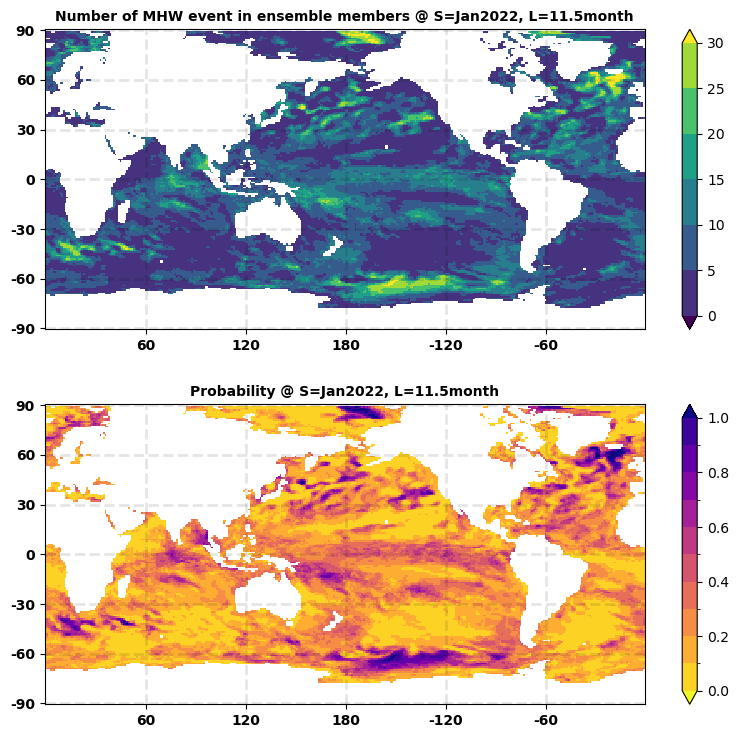

In [31]:
# comparing zos  
# import cartopy.mpl.ticker as cticker
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(2,figsize=(15,15))
fontsize = 10
num_level = np.arange(0, 30+1, 5)
level = np.arange(0, 1+0.1, 0.1)

# mhw event figure
ax2 = fig.add_axes([0,0.5,0.5,0.20])
im = (
    (da_mhw_event.sum(dim='M')*da_landmask)
        .plot.pcolormesh(
            x='X',
            y='Y',
            ax=ax2, 
            levels=num_level, 
            extend='both', 
            cmap='viridis'
        )
)
ax2.set_title('Number of MHW event in ensemble members @ S=Jan2022, L=11.5month', color='black', weight='bold',size=fontsize)
ax2 = plot_format(ax2,font_size=fontsize)

# mhw probability figure
ax3 = fig.add_axes([0,0.25,0.5,0.20])
im = (
    (da_mhw_event.sum(dim='M')/da_mhw_event.M.max()*da_landmask)
        .plot.pcolormesh(
            x='X',
            y='Y',
            ax=ax3, 
            levels=level, 
            extend='both', 
            cmap='plasma_r'
        )
)
ax3.set_title('Probability @ S=Jan2022, L=11.5month', color='black', weight='bold',size=fontsize)
ax3 = plot_format(ax3,font_size=fontsize)
